In [1]:
# jax
import jax
# jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
from jax.random import PRNGKey as pkey
from jax.scipy.linalg import solve
# Other libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use("ggplot")
from importlib import reload
from functools import partial

# Our libraries
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import (OperatorModel, OperatorPDEModel,CholInducedRKHS,
                            CholOperatorModel)
import plotting
reload(plotting)
from plotting import (plot_obs,plot_compare_error,
                      plot_input_data,plot_compare_error,
                      plot_obs_parabolic, plot_init_final_parabolic)

from evaluation_metrics import get_nrmse,table_u_errors
from data_utils import (
    get_xy_grid_pairs, # changed - could live in parabolic_data_utils ?
    build_xy_grid,
    sample_xy_grid_latin,
    build_input_observations,
    build_u_obs_single,
    build_u_obs_all,
    sample_multiple_xy_grids_latin
)

from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data,
    GP_Sampler_1D_Pinned
)

from Kernels import (
    get_gaussianRBF,
    get_centered_scaled_poly_kernel,
    fit_kernel_params,log1pexp,
    inv_log1pexp,get_anisotropic_gaussianRBF
)

In [2]:
# Sample m training functions from a GP
m = 3
kernel_GP = get_gaussianRBF(0.2)
xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
u0_true_functions = tuple(GP_Sampler_1D_Pinned(num_samples = m,
                                        X = xy_pts, 
                                        smooth= 2,
                                        kernel = kernel_GP,
                                        reg = 1e-8,
                                        seed = 2024
                                    )
                          )

vec_u0_true_functions = tuple([np.vectorize(u) for u in u0_true_functions])
vmapped_u0_true_functions = tuple([jax.vmap(u) for u in u0_true_functions])
# Solve m Burgers' equations with IC's: u0_true_functions 
kappa = 0.001
alpha = 5.

u_true_functions = []
ut_true_functions = []
interpolants = []
t_vals_s = []
sols_s = []

for u0_true_function in vec_u0_true_functions:
  res = list(build_burgers_data(func_u0=u0_true_function,
                       kappa = kappa,
                       alpha = alpha,
                       k_timestep=0.0001,
                       n_finite_diff=1999))
  u_true_functions.append(res[0])
  ut_true_functions.append(res[1])
  interpolants.append(res[2])
  t_vals_s.append(res[3])
  sols_s.append(res[4])

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

In [3]:
# Ghost Chebyshev grids
# num_grid_x = 31
# num_grid_t = 26
num_grid_x = 7
num_grid_t = 6
tx_ints , tx_bdys = [], []
for _ in range(m):
    res = build_tx_grid_chebyshev([0,1],[0,1],
                            num_grid_t,
                            num_grid_x,
                            alpha = 0.5)
    tx_ints.append(res[0])
    tx_bdys.append(res[1])

tx_ints = tuple(tx_ints)
tx_bdys = tuple(tx_bdys)
# Tuple of ghost grids
tx_all = tuple(jnp.vstack([tx_int,tx_bdy]) for tx_int,tx_bdy in zip(tx_ints,tx_bdys))

In [4]:
# List of number of observation points per u
num_obs = [4]*m

# Get (X^m, u^m(X^m))
tx_obs = []
u_obs = []
num_points = 40
for i, (tx_int,tx_bdy) in enumerate(zip(tx_ints,tx_bdys)):
    _,tx_ob = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs[i],
        jax.random.PRNGKey(i),
        times_to_observe = (0,)
            )
    tx_obs.append(tx_ob)

u_obs = tuple(u(tx_ob) for tx_ob,u in zip(tx_obs,u_true_functions))

In [5]:
# Define grid to plot
num_fine_grid = 300
initial_time = 0
final_time = 1
t_fine,x_fine = jnp.meshgrid(jnp.linspace(initial_time,final_time,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T

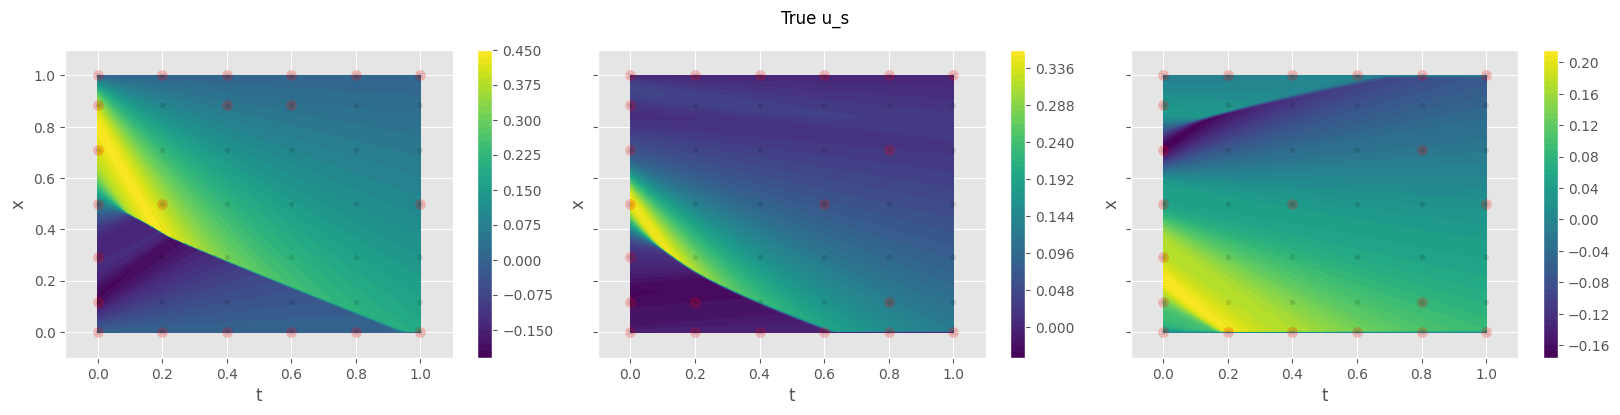

In [6]:
# Plot u's
plot_obs_parabolic(tx_fine, tx_all, tx_obs, u_true_functions, title = 'True u_s')

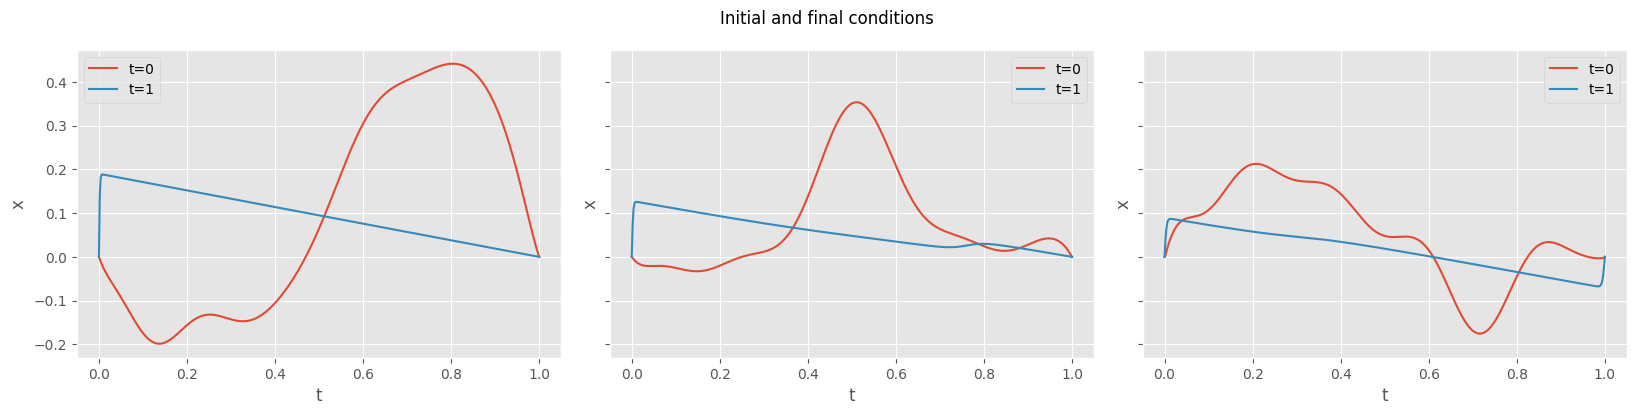

In [7]:
# Plot initial and final conditions
num_fine_grid = 500
grid_points = jnp.linspace(0,1,num_fine_grid)
plot_init_final_parabolic(grid_points, u_true_functions, title = 'Initial and final conditions')

In [8]:
type(u_obs)

tuple

In [9]:
# Features of u and P
u_operators = (eval_k,) # This enforces 1_5 step method
feature_operators = (eval_k,dx_k,dxx_k)


# Fit parameters of kernel for u
def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params_s = []
ml_value_s = []
k_u_s = []
for i in range(m):
    res = fit_kernel_params(param_ani_gaussian_RBF,tx_obs[i],u_obs[i],jnp.zeros(2))
    ML_lengthscales = log1pexp(res[0])
    k_u_s.append(get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(res[0]))))
    print(1/(jnp.sqrt(ML_lengthscales)))

u_models = tuple([CholInducedRKHS(
    tx_all[i],
    u_operators,
    k_u_s[i]
    ) for i in range(m)])

[1.01464204 0.10914972]
[2.02378045 0.17812676]
[12.20478121  0.18587996]


In [10]:
# Get necessary tuples
observation_points = tuple(tx_obs)
observation_values = tuple(u_obs)
collocation_points = tx_ints

all_u_params_init = tuple([
    model.get_fitted_params(obs_loc,obs_val)
    for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

grid_features_u_init = jnp.vstack([(
    model.evaluate_operators(feature_operators,tx_int,model_params)).reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        ) for tx_int,model,model_params in zip(tx_ints,u_models,all_u_params_init)])

In [11]:
k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_u_init,c=1.,scaling = 'diagonal')

@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])

P_model = OperatorModel(k_P)

In [12]:
EqnModel  = OperatorPDEModel(
    P_model,
    u_models,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 5.,
    )

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.06733, Jres = 4.234, alpha = 0.08333, improvement_ratio = 0.9758
Iteration 1, loss = 0.04917, Jres = 1.674, alpha = 0.06944, improvement_ratio = 0.9975
Iteration 2, loss = 0.03536, Jres = 2.209, alpha = 0.05787, improvement_ratio = 0.9675
Iteration 3, loss = 0.0218, Jres = 3.005, alpha = 0.04823, improvement_ratio = 1.103
Iteration 4, loss = 0.01488, Jres = 0.4684, alpha = 0.04019, improvement_ratio = 1.074
Iteration 5, loss = 0.012, Jres = 1.235, alpha = 0.03349, improvement_ratio = 0.9821
Iteration 100, loss = 0.001555, Jres = 0.4323, alpha = 3.201e-06, improvement_ratio = 0.841
Iteration 200, loss = 0.001307, Jres = 0.004148, alpha = 8.333e-07, improvement_ratio = 0.9939
Iteration 300, loss = 0.001188, Jres = 0.006952, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 400, loss = 0.00111, Jres = 0.01111, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 500, loss = 0.001058, Jres = 0.007085, alpha = 8.333e-07, improvement_ratio = 1.001


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 0.0010569850620397673


/tmp/ipykernel_3372957/3222514599.py:17: DeprecationWarning: hstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))


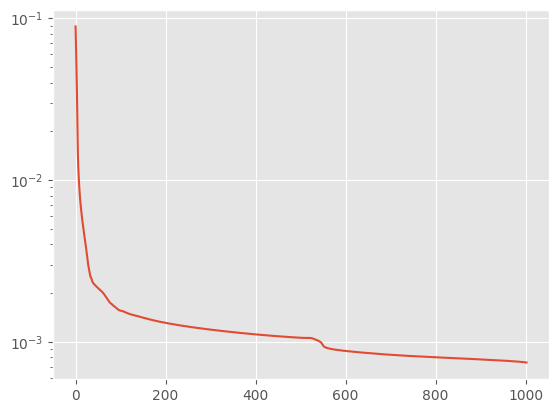

In [13]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize,adaptive_refine_solution
params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(tx_ints[0]))])

params,convergence_data = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    max_iter = 501,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    print_every = 100
)
p_adjusted,refine_convergence_data = adaptive_refine_solution(params,EqnModel,1e-3,500)
plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))
plt.yscale('log')
plt.show()